Using device: cuda
Loading data...
Data loaded in 8.46 seconds
Preprocessing data...
Stratification failed - using random split
Model has 2,440,436 parameters
Starting training with focus on Component 4...


<ipython-input-5-bba146cd2f1c>:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)



Epoch 1 [0.5s]:
Train Loss: 0.092778 | Val Loss: 0.028404
Component Metrics:
  Comp 1: Train MSE 0.059061 | Val MSE 0.036938 | Val Corr 0.8357
  Comp 2: Train MSE 0.106313 | Val MSE 0.052420 | Val Corr 0.9096
  Comp 3: Train MSE 0.034980 | Val MSE 0.011199 | Val Corr 0.9072
  Comp 4: Train MSE 0.048707 | Val MSE 0.021856 | Val Corr 0.9132

Epoch 2 [0.5s]:
Train Loss: 0.021211 | Val Loss: 0.015737
Component Metrics:
  Comp 1: Train MSE 0.034360 | Val MSE 0.031521 | Val Corr 0.8466
  Comp 2: Train MSE 0.048620 | Val MSE 0.043933 | Val Corr 0.9193
  Comp 3: Train MSE 0.007481 | Val MSE 0.008465 | Val Corr 0.9469
  Comp 4: Train MSE 0.017969 | Val MSE 0.017439 | Val Corr 0.9410

Epoch 3 [0.4s]:
Train Loss: 0.011711 | Val Loss: 0.008348
Component Metrics:
  Comp 1: Train MSE 0.030969 | Val MSE 0.030490 | Val Corr 0.8559
  Comp 2: Train MSE 0.041013 | Val MSE 0.039008 | Val Corr 0.9273
  Comp 3: Train MSE 0.006296 | Val MSE 0.003831 | Val Corr 0.9553
  Comp 4: Train MSE 0.013625 | Val MSE 0

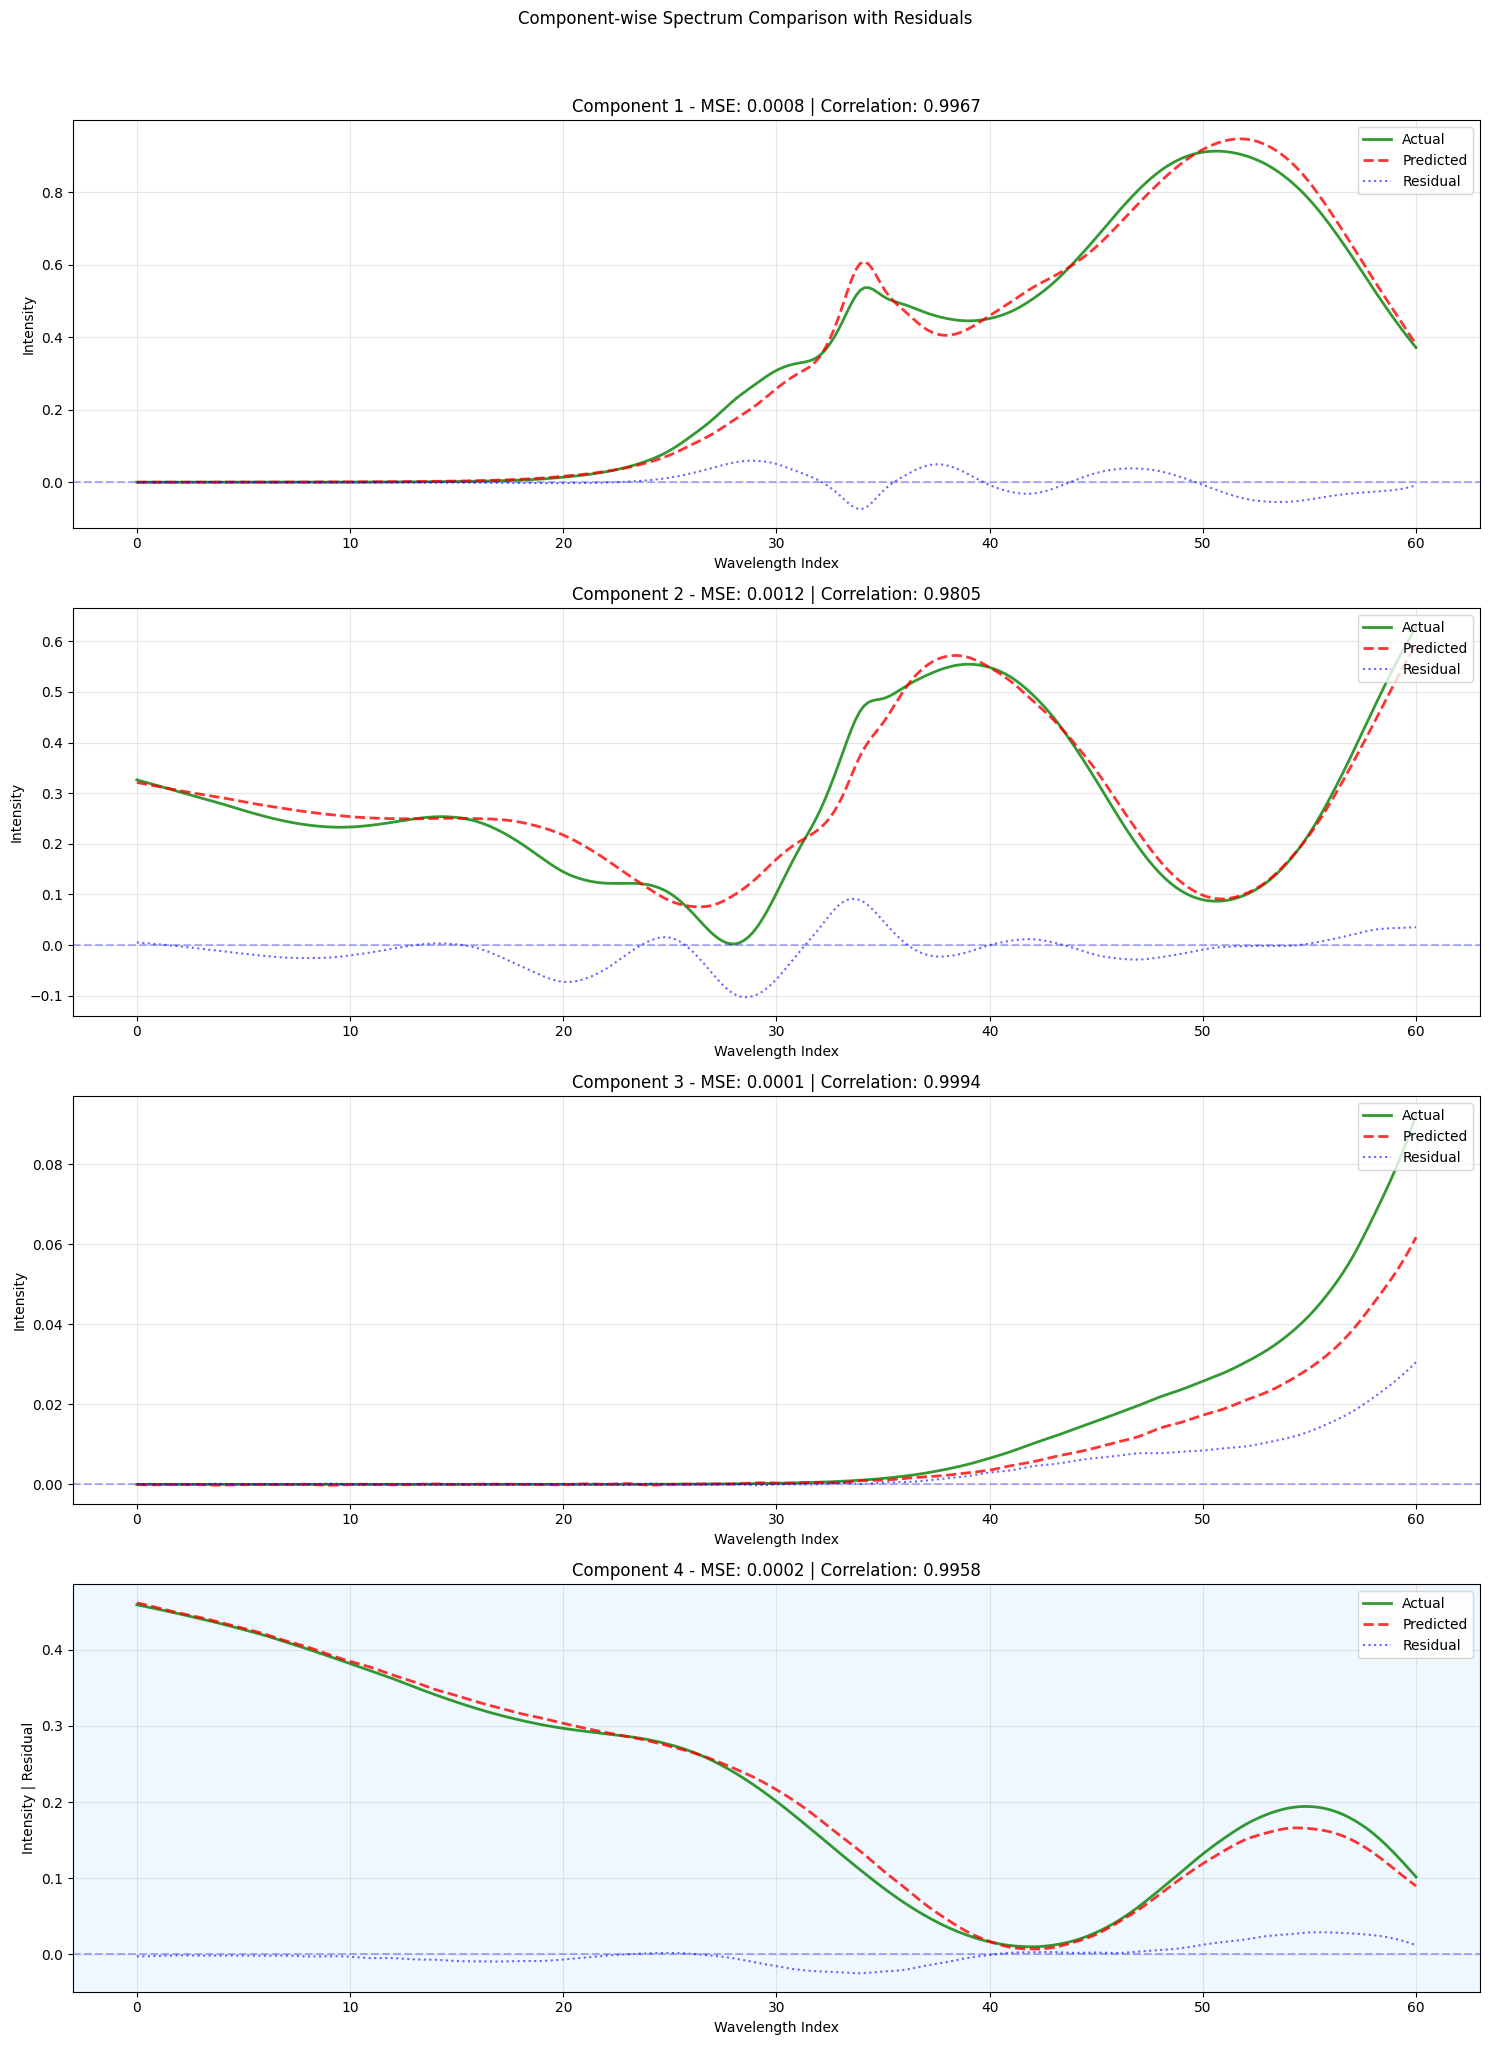

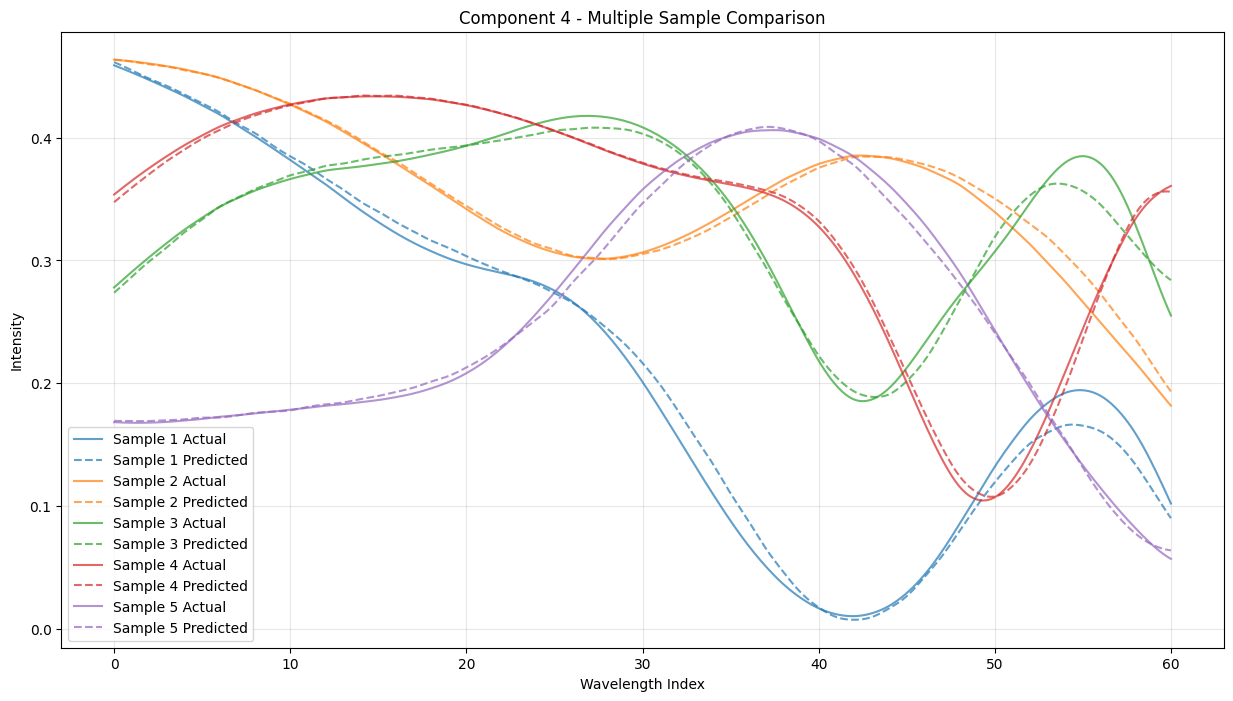

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time
from scipy.interpolate import make_interp_spline

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mixed precision training
use_amp = device.type == 'cuda'

# Load data
print("Loading data...")
start_time = time()
X = np.loadtxt(r'/content/drive/MyDrive/Unsupervised/structures_120k.txt')[:30000]
Y = np.loadtxt(r'/content/drive/MyDrive/Unsupervised/spectra_120k.dat').reshape(-1, 61, 4)[:30000]
print(f"Data loaded in {time()-start_time:.2f} seconds")

# Preprocessing
print("Preprocessing data...")
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

# Data splitting
spectra_sums = Y.sum(axis=(1,2))
try:
    stratify_bins = np.digitize(spectra_sums, bins=np.quantile(spectra_sums, np.linspace(0, 1, 5)))
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=stratify_bins)
except ValueError:
    print("Stratification failed - using random split")
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
Y_train = torch.FloatTensor(Y_train).to(device)
Y_test = torch.FloatTensor(Y_test).to(device)

# DataLoader setup
batch_size = 1024 if torch.cuda.is_available() else 512
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Enhanced Model Architecture with Focus on Component 4
class SpectralModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=1024):
        super().__init__()
        # Shared base network
        self.base_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.GELU()
        )

        # Specialized heads with enhanced architecture for Component 4
        self.heads = nn.ModuleList([
            # Component 1 head
            nn.Sequential(
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.GELU(),
                nn.Linear(hidden_size//4, 61)
            ),
            # Component 2 head
            nn.Sequential(
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.GELU(),
                nn.Linear(hidden_size//4, 61)
            ),
            # Component 3 head
            nn.Sequential(
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.GELU(),
                nn.Linear(hidden_size//4, 61)
            ),
            # Component 4 head (enhanced)
            nn.Sequential(
                nn.Linear(hidden_size//2, hidden_size//2),
                nn.BatchNorm1d(hidden_size//2),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.GELU(),
                nn.Linear(hidden_size//4, 61)
            )
        ])

    def forward(self, x):
        x = self.base_net(x)
        return torch.stack([head(x) for head in self.heads], dim=-1)

model = SpectralModel().to(device)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Optimizer with component-specific settings
optimizer = optim.AdamW([
    {'params': model.base_net.parameters()},
    {'params': model.heads[0].parameters(), 'weight_decay': 1e-5},
    {'params': model.heads[1].parameters(), 'weight_decay': 1e-5},
    {'params': model.heads[2].parameters(), 'weight_decay': 1e-5},
    {'params': model.heads[3].parameters(), 'weight_decay': 5e-6}  # Less regularization for Component 4
], lr=0.001)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=200,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Enhanced Loss Function with Focus on Component 4
class ComponentAwareLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Higher weight for Component 4
        self.comp_weights = torch.tensor([1.0, 1.0, 1.0, 1.5]).view(1,1,4).to(device)
        # Special peak weights for Component 4
        self.peak_weights = torch.tensor(
            [1.0]*15 + [1.2]*15 + [1.5]*15 + [2.0]*16  # Increasing weights for higher wavelengths
        ).view(1,61,1).to(device)

    def forward(self, y_pred, y_true):
        # Weighted MSE loss
        mse_loss = (self.comp_weights * (y_pred - y_true)**2).mean()

        # Enhanced spectral correlation
        pred_norm = y_pred / (y_pred.norm(dim=1, keepdim=True) + 1e-6)
        true_norm = y_true / (y_true.norm(dim=1, keepdim=True) + 1e-6)
        cosine_sim = (self.comp_weights * (pred_norm * true_norm)).sum(dim=1).mean()
        angle_loss = 1 - cosine_sim

        # Peak-sensitive loss
        peak_loss = (self.comp_weights * self.peak_weights * (y_pred - y_true)**2).mean()

        return 0.4*mse_loss + 0.3*angle_loss + 0.3*peak_loss

criterion = ComponentAwareLoss()

# Training loop with component monitoring
def train(model, loader, optimizer, criterion, scheduler, scaler):
    model.train()
    total_loss = 0
    component_losses = [0]*4

    for X_batch, Y_batch in loader:
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)

            # Track component losses
            with torch.no_grad():
                for i in range(4):
                    component_losses[i] += F.mse_loss(Y_pred[...,i], Y_batch[...,i]).item()

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    component_losses = [l/len(loader) for l in component_losses]
    return avg_loss, component_losses

# Validation with detailed component analysis
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    component_losses = [0]*4
    component_corrs = [0]*4

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            Y_pred = model(X_batch)
            total_loss += criterion(Y_pred, Y_batch).item()

            for i in range(4):
                component_losses[i] += F.mse_loss(Y_pred[...,i], Y_batch[...,i]).item()
                pred_norm = Y_pred[...,i] / (Y_pred[...,i].norm(dim=1, keepdim=True) + 1e-6)
                true_norm = Y_batch[...,i] / (Y_batch[...,i].norm(dim=1, keepdim=True) + 1e-6)
                component_corrs[i] += (pred_norm * true_norm).sum(dim=1).mean().item()

    avg_loss = total_loss / len(loader)
    component_losses = [l/len(loader) for l in component_losses]
    component_corrs = [c/len(loader) for c in component_corrs]
    return avg_loss, component_losses, component_corrs

# Training execution
best_loss = float('inf')
patience = 15
no_improve = 0
train_history = []
val_history = []

print("Starting training with focus on Component 4...")

for epoch in range(200):
    start_time = time()

    # Train and validate
    train_loss, train_comp_loss = train(model, train_loader, optimizer, criterion, scheduler, scaler)
    val_loss, val_comp_loss, val_comp_corr = validate(model, test_loader, criterion)

    # Save history
    train_history.append((train_loss, train_comp_loss))
    val_history.append((val_loss, val_comp_loss, val_comp_corr))

    # Early stopping and model checkpoint
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_spectral_model.pth')
    else:
        no_improve += 1

    # Print progress
    epoch_time = time() - start_time
    print(f"\nEpoch {epoch+1} [{epoch_time:.1f}s]:")
    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    print("Component Metrics:")
    for i in range(4):
        print(f"  Comp {i+1}: Train MSE {train_comp_loss[i]:.6f} | "
              f"Val MSE {val_comp_loss[i]:.6f} | Val Corr {val_comp_corr[i]:.4f}")

    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Enhanced visualization with proper residual plotting
def plot_component_focus(model, loader, sample_idx=0):
    model.eval()
    with torch.no_grad():
        X_sample, Y_sample = next(iter(loader))
        Y_pred = model(X_sample)

        actual = Y_sample[sample_idx].cpu().numpy()
        predicted = Y_pred[sample_idx].cpu().numpy()

        fig, axs = plt.subplots(4, 1, figsize=(15, 20))
        component_names = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

        for i in range(4):
            # Create smooth curves
            x = np.linspace(0, 60, 300)
            spline_actual = make_interp_spline(np.arange(61), actual[:,i], k=3)
            spline_pred = make_interp_spline(np.arange(61), predicted[:,i], k=3)

            # Plot actual vs predicted
            axs[i].plot(x, spline_actual(x), 'g-', label='Actual', alpha=0.8, linewidth=2)
            axs[i].plot(x, spline_pred(x), 'r--', label='Predicted', alpha=0.8, linewidth=2)

            # Calculate and plot residuals
            residual = actual[:,i] - predicted[:,i]
            spline_residual = make_interp_spline(np.arange(61), residual, k=3)
            axs[i].plot(x, spline_residual(x), 'b:', label='Residual', alpha=0.6, linewidth=1.5)
            axs[i].axhline(0, color='b', linestyle='--', alpha=0.3)

            # Calculate metrics
            mse = np.mean((actual[:,i] - predicted[:,i])**2)
            corr = np.corrcoef(actual[:,i], predicted[:,i])[0,1]

            axs[i].set_title(f"{component_names[i]} - MSE: {mse:.4f} | Correlation: {corr:.4f}")
            axs[i].set_xlabel('Wavelength Index')
            axs[i].set_ylabel('Intensity')
            axs[i].legend(loc='upper right')
            axs[i].grid(True, alpha=0.3)

            # Highlight Component 4
            if i == 3:
                axs[i].set_facecolor('#F0F8FF')  # Light blue background
                axs[i].set_ylabel('Intensity | Residual', color='k')

        plt.suptitle("Component-wise Spectrum Comparison with Residuals", y=1.02)
        plt.tight_layout()
        plt.show()

# Load best model and visualize
model.load_state_dict(torch.load('best_spectral_model.pth'))
plot_component_focus(model, test_loader)

# Additional diagnostic plot for Component 4
def plot_component_4_diagnostics(model, loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        X_sample, Y_sample = next(iter(loader))
        Y_pred = model(X_sample[:num_samples])

        actual = Y_sample[:num_samples].cpu().numpy()
        predicted = Y_pred.cpu().numpy()

        plt.figure(figsize=(15, 8))

        # Plot multiple samples for Component 4
        for i in range(num_samples):
            # Create smooth curves
            x = np.linspace(0, 60, 300)
            spline_actual = make_interp_spline(np.arange(61), actual[i,:,3], k=3)
            spline_pred = make_interp_spline(np.arange(61), predicted[i,:,3], k=3)

            # Plot with different colors for each sample
            plt.plot(x, spline_actual(x), color=plt.cm.tab10(i), linestyle='-', alpha=0.7,
                    label=f'Sample {i+1} Actual')
            plt.plot(x, spline_pred(x), color=plt.cm.tab10(i), linestyle='--', alpha=0.7,
                    label=f'Sample {i+1} Predicted')

        plt.title("Component 4 - Multiple Sample Comparison")
        plt.xlabel('Wavelength Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

plot_component_4_diagnostics(model, test_loader)